# Language Model analysis

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np

from gensim.models import Word2Vec
from gensim import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# embedding models, base model
model_path = "/Users/khosseini/myJobs/ATI/Projects/2019/Living-with-Machines-code/language-lab-mro/lexicon_expansion/interactive_expansion/models/all_books/w2v_005/w2v_words.model"
w2v = Word2Vec.load(model_path)

# OCR model, quality 1, 2
model_path = "/Users/khosseini/myJobs/ATI/Projects/2019/lwm_ocr_assessment/LMs/w2v_005_EM_ocr_qual_1_2.model"
w2v_em_ocr_qual_1_2 = Word2Vec.load(model_path)

# corrected model, quality 1, 2
model_path = "/Users/khosseini/myJobs/ATI/Projects/2019/lwm_ocr_assessment/LMs/w2v_005_EM_corr_qual_1_2.model"
w2v_em_corr_qual_1_2 = Word2Vec.load(model_path)

# OCR model, quality 3, 4
model_path = "/Users/khosseini/myJobs/ATI/Projects/2019/lwm_ocr_assessment/LMs/w2v_005_EM_ocr_qual_3_4.model"
w2v_em_ocr_qual_3_4 = Word2Vec.load(model_path)

# corrected model, quality 3, 4
model_path = "/Users/khosseini/myJobs/ATI/Projects/2019/lwm_ocr_assessment/LMs/w2v_005_EM_corr_qual_3_4.model"
w2v_em_corr_qual_3_4 = Word2Vec.load(model_path)

2019-11-20 10:25:02,818 : INFO : loading Word2Vec object from /Users/khosseini/myJobs/ATI/Projects/2019/Living-with-Machines-code/language-lab-mro/lexicon_expansion/interactive_expansion/models/all_books/w2v_005/w2v_words.model
2019-11-20 10:25:03,862 : INFO : loading wv recursively from /Users/khosseini/myJobs/ATI/Projects/2019/Living-with-Machines-code/language-lab-mro/lexicon_expansion/interactive_expansion/models/all_books/w2v_005/w2v_words.model.wv.* with mmap=None
2019-11-20 10:25:03,862 : INFO : loading vectors from /Users/khosseini/myJobs/ATI/Projects/2019/Living-with-Machines-code/language-lab-mro/lexicon_expansion/interactive_expansion/models/all_books/w2v_005/w2v_words.model.wv.vectors.npy with mmap=None
2019-11-20 10:25:04,153 : INFO : setting ignored attribute vectors_norm to None
2019-11-20 10:25:04,154 : INFO : loading vocabulary recursively from /Users/khosseini/myJobs/ATI/Projects/2019/Living-with-Machines-code/language-lab-mro/lexicon_expansion/interactive_expansion/m

In [3]:
def found_neighbors(myrow, embedding, colname='vocab', topn=1):
    try:
        vocab_neigh = embedding.wv.most_similar([myrow['vocab']], topn=topn)
        return list(np.array(vocab_neigh)[:, 0])
    except KeyError:
        return []

In [4]:
def jaccard_similarity_df(myrow, colname_1, colname_2, make_lowercase=True):
    """
    Jaccard similarity between two documents (e.g., OCR and Human) on flattened list of words
    """
    list1 = myrow[colname_1]
    list2 = myrow[colname_2]
    if make_lowercase:
        list1 = [x.lower() for x in list1]
        list2 = [x.lower() for x in list2]
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# Quality bands 3, 4

## Create list of words and their frequencies in the corrected set

In [5]:
words_corrected = []
for item in w2v_em_corr_qual_3_4.wv.vocab:
    words_corrected.append([item, int(w2v_em_corr_qual_3_4.wv.vocab[item].count)])

In [6]:
pd_words = pd.DataFrame(words_corrected, columns=['vocab', 'count'])

In [7]:
pd_words = pd_words.sort_values(by=['count'], ascending=False)
print("size: {}".format(len(pd_words)))
pd_words.head()

size: 435768


,vocab,count
55,the,292057861
113,of,174249213
11,.,167569112
39,and,139611448
106,to,108817438


In [8]:
pd2search = pd_words[0:5000]
pd2search

,vocab,count
55,the,292057861
113,of,174249213
11,.,167569112
39,and,139611448
106,to,108817438
...,...,...
5444,attendants,69723
8140,smallest,69721
5006,subjected,69691
17941,diamond,69681


In [9]:
neigh_jaccard_bands_3_4 = []

for topn in [1, 2, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]:
    print("topn: {}".format(topn))
    t1 = time.time()
    
    pd2search = pd_words[0:1000]
    pd2search['w2v_em_corr_qual_3_4'] = pd2search.apply(found_neighbors, args=[w2v_em_corr_qual_3_4, 
                                                                               'vocab', 
                                                                               topn], axis=1)
    print("corr: {}".format(time.time() - t1))
    pd2search['w2v_em_ocr_qual_3_4'] = pd2search.apply(found_neighbors, args=[w2v_em_ocr_qual_3_4, 
                                                                             'vocab', 
                                                                              topn], axis=1)
    pd2search['jaccard_qual_3_4'] = \
        pd2search.apply(jaccard_similarity_df, args=['w2v_em_corr_qual_3_4', 
                                                     "w2v_em_ocr_qual_3_4", 
                                                     True], 
                        axis=1)
    
    neigh_jaccard_bands_3_4.append(
        [topn, 
         pd2search['jaccard_qual_3_4'].mean(), 
         pd2search['jaccard_qual_3_4'].std()])
    
    print("total: {}".format(time.time() - t1))

neigh_jaccard_bands_3_4 = np.array(neigh_jaccard_bands_3_4)

2019-11-20 10:25:20,713 : INFO : precomputing L2-norms of word weight vectors


topn: 1


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
2019-11-20 10:25:51,951 : INFO : precomputing L2-norms of word weight vectors


corr: 31.237623929977417


/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/khosseini/anaconda3/envs/py37torch/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


total: 61.48869228363037
topn: 2
corr: 27.80425500869751
total: 55.90272307395935
topn: 5
corr: 50.36992001533508
total: 81.75385403633118
topn: 10
corr: 33.88920593261719
total: 82.7456169128418
topn: 50
corr: 51.276532888412476
total: 102.47708582878113
topn: 100
corr: 51.460448026657104
total: 102.94135189056396
topn: 500
corr: 53.83084583282471
total: 112.25507879257202
topn: 1000
corr: 55.207464933395386
total: 110.42541694641113
topn: 5000
corr: 79.14010500907898
total: 161.54402709007263
topn: 10000
corr: 111.02097487449646
total: 216.28135085105896
topn: 50000
corr: 267.5976622104645
total: 564.6404500007629


# Quality bands 1, 2

## Create list of words and their frequencies in the corrected set

In [ ]:
# words_corrected = []
for item in w2v_em_corr_qual_1_2.wv.vocab:
    words_corrected.append([item, int(w2v_em_corr_qual_1_2.wv.vocab[item].count)])

In [ ]:
pd_words = pd.DataFrame(words_corrected, columns=['vocab', 'count'])

In [ ]:
pd_words = pd_words.sort_values(by=['count'], ascending=False)
print("size: {}".format(len(pd_words)))
pd_words.head()

In [ ]:
pd2search = pd_words[0:5000]
pd2search

In [ ]:
neigh_jaccard_bands_1_2 = []

for topn in [1, 2, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000]:
    print("topn: {}".format(topn))
    t1 = time.time()
    
    pd2search = pd_words[0:1000]
    pd2search['w2v_em_corr_qual_1_2'] = pd2search.apply(found_neighbors, args=[w2v_em_corr_qual_1_2, 
                                                                               'vocab', 
                                                                               topn], axis=1)
    print("corr: {}".format(time.time() - t1))
    pd2search['w2v_em_ocr_qual_1_2'] = pd2search.apply(found_neighbors, args=[w2v_em_ocr_qual_1_2, 
                                                                             'vocab', 
                                                                              topn], axis=1)
    pd2search['jaccard_qual_1_2'] = \
        pd2search.apply(jaccard_similarity_df, args=['w2v_em_corr_qual_1_2', 
                                                     "w2v_em_ocr_qual_1_2", 
                                                     True], 
                        axis=1)
    
    neigh_jaccard_bands_1_2.append(
        [topn, 
         pd2search['jaccard_qual_1_2'].mean(), 
         pd2search['jaccard_qual_1_2'].std()])
    
    print("total: {}".format(time.time() - t1))

neigh_jaccard_bands_1_2 = np.array(neigh_jaccard_bands_1_2)

In [10]:
neigh_jaccard_bands_1_2 = np.load("neigh_jaccard_bands_1_2.npy")

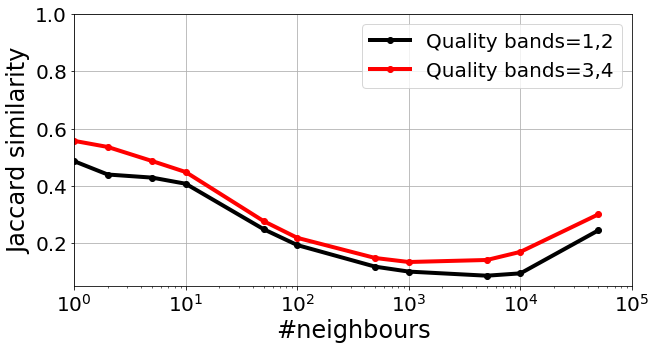

In [11]:
plt.figure(figsize=(10, 5))


plt.plot(neigh_jaccard_bands_1_2[:, 0], neigh_jaccard_bands_1_2[:, 1], 
         'k-o', alpha=1.0, 
         lw=4,
         label='Quality bands=1,2')

plt.plot(neigh_jaccard_bands_3_4[:, 0], neigh_jaccard_bands_3_4[:, 1], 
         'r-o', alpha=1.0, 
         lw=4,
         label='Quality bands=3,4')

plt.grid()
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel("#neighbours", size=24)
plt.ylabel("Jaccard similarity", size=24)
plt.xscale("log")
plt.xlim(1.0, 100000)
plt.ylim(0.05, 1.0)

plt.legend(prop={'size': 20})
plt.show()
#plt.xlim(0, 20000)